# Plot Training Variables

All the training variables need to be plotted. If all goes well, this script will plot them all.

In [1]:
jobId = 106

## Initalization

In [2]:
from bdt_training_scikit_tools import load_trimmed_sample, default_training_variable_list, \
    test_train_samples, prep_samples, default_training, calc_performance, get_fraction_of_events, \
    default_training_variable_list
import matplotlib.pyplot as plt
plt.rc('font', size=14)
from matplotlib.colors import LogNorm
import pandas as pd
import numpy as np
import multiprocessing as mp
import itertools

In [3]:
from matplotlib import rcParams
rcParams['xtick.direction'] = 'in'
rcParams['ytick.direction'] = 'in'

## Load Data

In [4]:
%%time
input_events = load_trimmed_sample(jobId)

Job 106:
  BIB: 800000 events
  Multijet: 800000 events
  Signal: 800000 events
  [800000, 800000, 504190]
Wall time: 19.1 s


## Plotting Routines and Defines

In [5]:
hist_options = {
    'EnergyDensity': {'range': [0, 0.6]},
    'BIBDeltaTimingM': {'range': [-20.0, 50.0]},
    'BIBDeltaTimingP': {'range': [-20.0, 50.0]},
    'HadronicLayer1Fraction': {'range': [-0.1, 1.0]},
    'ShowerCenter': {'range': [0.0, 4000.0]},
    'MaxTrackPt': {'range': [0.0, 30.0]},
    'PredictedLxy': {'range': [0.0, 4000.0]},
    'PredictedLz': {'range': [0.0, 7000.0]},
    'SumPtOfAllTracks': {'range': [0.0, 30.0]}
}
axis_labels = {
    'EnergyDensity' : 'Energy Density',
    'HadronicLayer1Fraction' : 'Hadronic Layer 1 Fraction',
    'ShowerCenter': 'Shower Center [mm]',
    'MaxTrackPt': 'Max Track $p_T$ [GeV]',
    'PredictedLxy': 'MLP $L_{xy}$ [mm]',
    'PredictedLz': 'MLP $L_z$ [mm]',
    'SumPtOfAllTracks': 'Sum $p_T$ of all Tracks [GeV]',
    'JetPt': "Jet $p_T$ [GeV]",
    'BIBDeltaTimingM': 'BIB Negative $\Delta T$ [ns]',
    'BIBDeltaTimingP': 'BIB Positive $\Delta T$ [ns]',
    'JetLat': 'Jet Latitude',
    'JetLong': 'Jet Longitude',
}

In [45]:
def make_point_histogram (ax, x):
    '''Histogram with data points
    
    Args:
        x - a 2D array of datasets
        ax - matplot lib subplot 
    
    '''
    
    # Get the bin range
    xmin = min([xi.min() for xi in x])
    xmax = max([xi.max() for xi in x])
    bin_range = (xmin, xmax)
    
    # Next, get the values and bins for each histogram
    x0values, bins = np.histogram(x[0], bins='auto')
    values = [x0values] + [np.histogram(xi, bins)[0] for xi in x[1:]]
    
    # Next, plot them
    central_bin_values = list(map(lambda x1,x2: x1+(x2-x1)/2.0, bins, bins[1:]))
    for v in values:
        ax.plot(central_bin_values, v)

def make_plot(events, varname, weighted = True):
    '''Plot the column varName'''
    
    # Histogram arguments
    histargs = {'bins': 40, 'histtype': 'step', 'normed': 1}
    if weighted:
        histargs['weights'] = (events[0]['Weight'].values, events[1]['Weight'].values, events[2]['Weight'].values)

    if varname in hist_options:
        histargs.update(hist_options[varname])
        
    # Plot the figure 
    fig = plt.figure(figsize=(18,12))
    ax = plt.subplot(221)
    #vals, bins, patches = ax.hist((events[0][varname].values, events[1][varname].values, events[2][varname].values), \
    #        label=('BIB', "Multijet", 'Signal'), \
    #        **histargs)
    #vals, bins, patches = ax.hist((events[0][varname].values), \
    #        label='BIB', \
    #        **histargs)
    make_point_histogram(ax, (events[0][varname].values, events[1][varname].values, events[2][varname].values))
    ax.set_ylabel('Fraction of Events', y = 1.0, horizontalalignment='right')
    
    alabel = varname
    if varname in axis_labels:
        varname = axis_labels[varname]
    ax.set_xlabel(varname, x = 1.0, horizontalalignment='right')
    
    # ATLAS Label
    ax.text(0.15, 0.85, 'ATLAS Internal',
        verticalalignment='bottom', horizontalalignment='left',
        transform=ax.transAxes,
        color='black', fontsize=24)
    ax.text(0.15, 0.78, '$\sqrt{s}=13$ TeV, 33 $fb^-1$',
        verticalalignment='bottom', horizontalalignment='left',
        transform=ax.transAxes,
        color='black', fontsize=15) 
    
    # Display it in the notebook output
    ax.legend(frameon=False)
    plt.show()

No handles with labels found to put in legend.


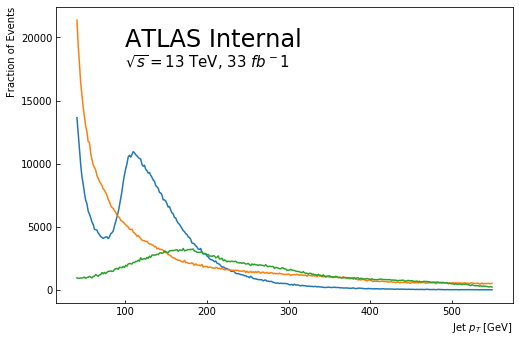

In [46]:
make_plot(input_events, 'JetPt', weighted=False)

## Plot All varables weighted

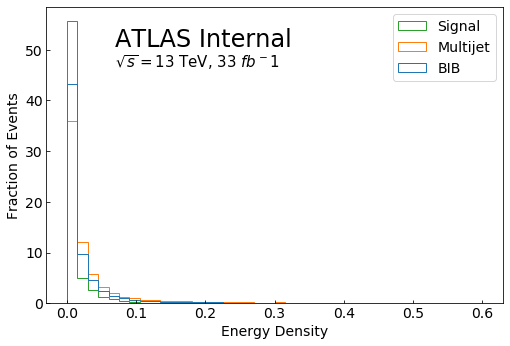

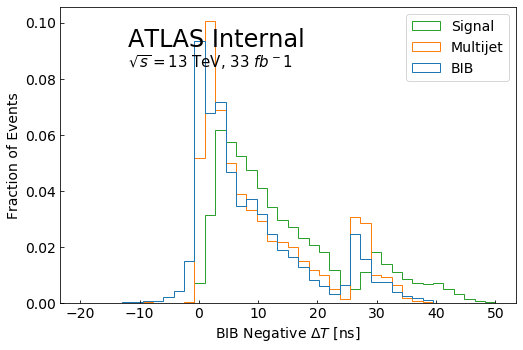

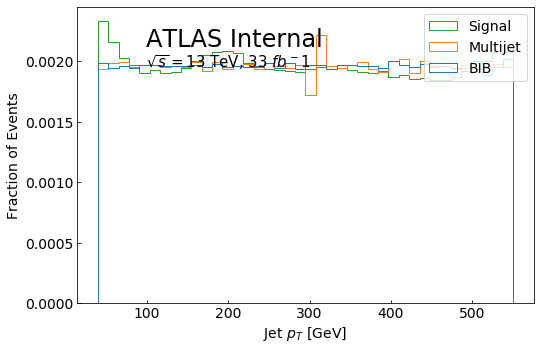

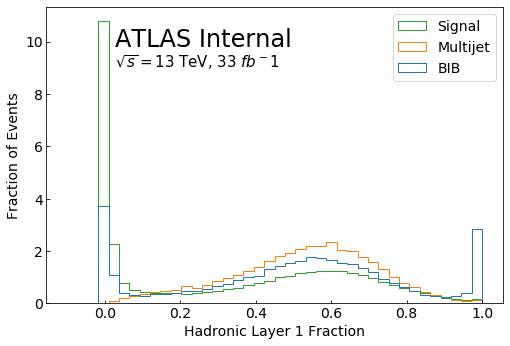

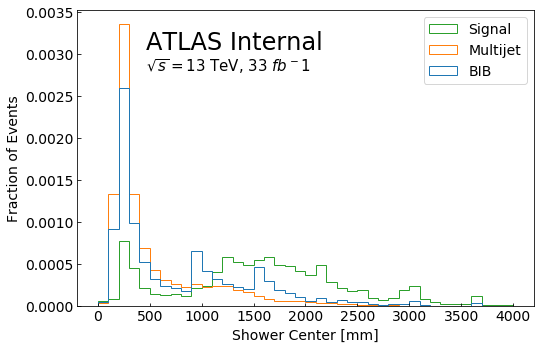

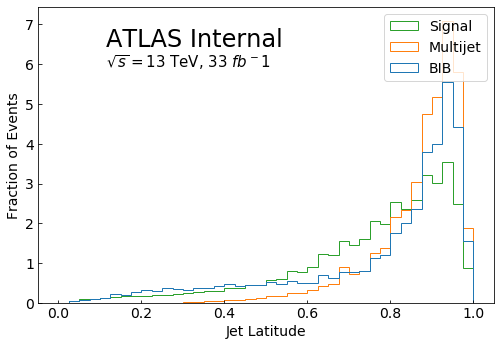

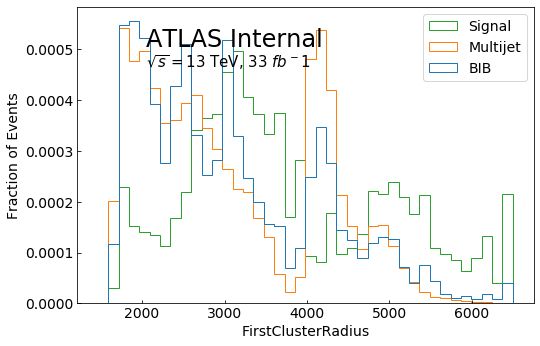

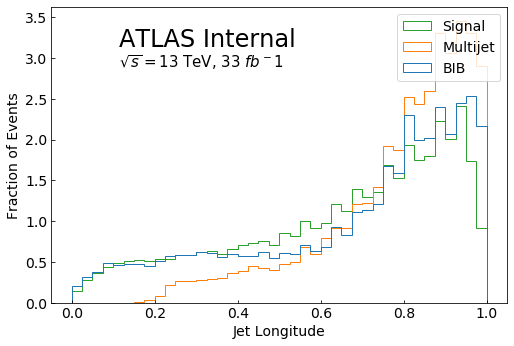

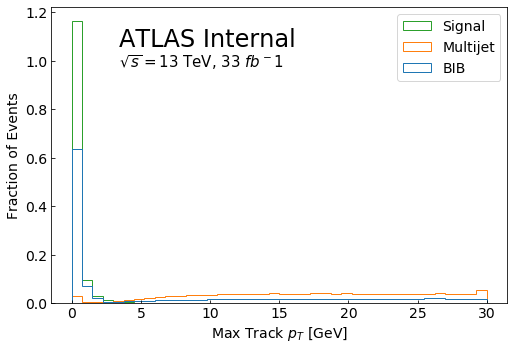

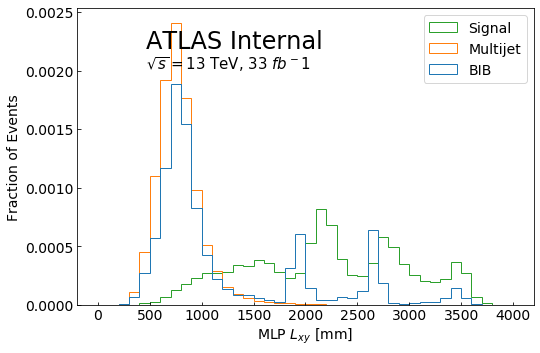

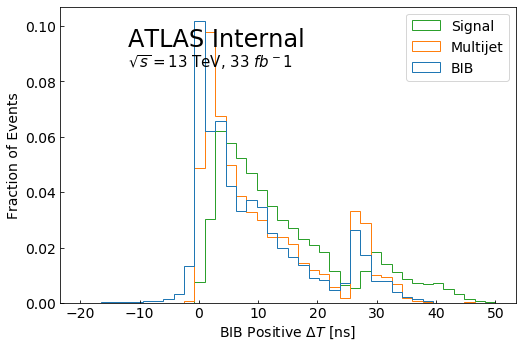

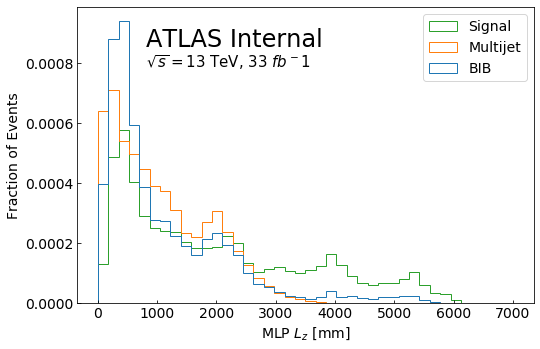

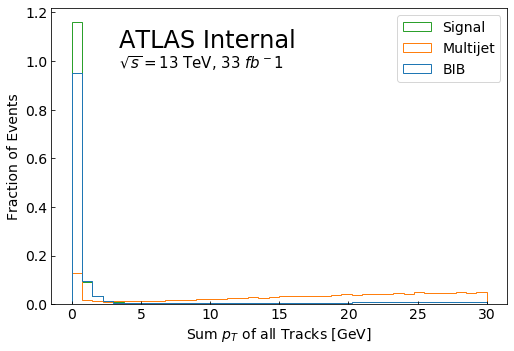

In [132]:
for var in default_training_variable_list:
    make_plot(input_events, var)